# Word Embeddings

Word embeddings can help with text processing tasks. Here, we learn word embeddings for the words used in the [IMDB dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification).

This example is taken from [*Deep Learning with Python*](https://github.com/fchollet/deep-learning-with-python-notebooks), F. Chollet, 2018, Section 3.5. 

We start by loading the raw IMDB dataset.

In [26]:
import os

imdb_dir = '/home/kvlinden/projects/tmp/cs344/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

# Do the same for the testing dataset.
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)         

We now tokenize the texts.

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Load pretrained GloVe embeddings (See [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)) and then build an embedding matrix that we can load into the Keras embedding layer.

In [28]:
glove_dir = '/home/kvlinden/projects/tmp/cs344/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


Build the model.

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Load the GloVe embeddings into the model and then train it.

In [30]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 2.2261 - acc: 0.4950 - val_loss: 0.7301 - val_acc: 0.5151
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5614 - acc: 0.7150 - val_loss: 0.8213 - val_acc: 0.5109
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4322 - acc: 0.7600 - val_loss: 0.7935 - val_acc: 0.5106
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2758 - acc: 0.9250 - val_loss: 0.7571 - val_acc: 0.5316
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2060 - acc: 0.9500 - val_loss: 1.1783 - val_acc: 0.4984
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1493 - acc: 0.9650 - val_loss: 1.0182 - val_acc: 0.5134
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1260 - acc: 0.9800 - val_loss: 0.8096 - val_acc: 0.5478
Epoch 8/10
200/200 [========

Plot the model performance.

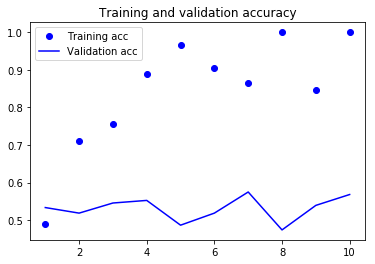

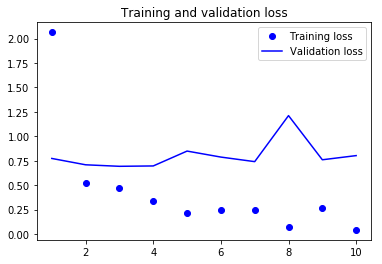

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Run the testing dataset.

In [25]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 68us/step


[0.8895373232269287, 0.527]

We now try a fresh model that self-trains the embedding layer.

In [16]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6936 - acc: 0.5200 - val_loss: 0.6908 - val_acc: 0.5326
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4874 - a

The plot shows the system performing in the low 50s.

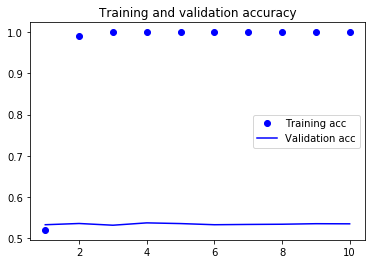

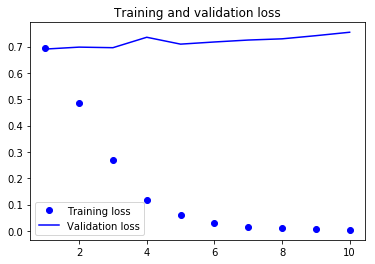

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Finally, we run on the testing set.

In [19]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 70us/step


[0.7720139757537842, 0.51716]